In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from matplotlib.pylab import rcParams
rcParams['figure.figsize']=20,10
from keras.models import Sequential
from keras.layers import LSTM,Dropout,Dense
from sklearn.preprocessing import MinMaxScaler

In [2]:
df=pd.read_csv("./Dataset/btc.csv")
df.head()

,Unix,Date,Symbol,Open,High,Low,Close,Volume BTC,Volume USDT,tradecount
0,1.688690e+12,7/7/2023,BTCUSDT,29895.42,30449.00,29701.02,30344.70,34070.53895,1.027462e+09,912948
1,1.688600e+12,7/6/2023,BTCUSDT,30504.80,31500.00,29850.45,29895.43,71319.62610,2.181764e+09,1397042
2,1.688520e+12,7/5/2023,BTCUSDT,30766.52,30878.07,30200.00,30504.81,33215.67122,1.013695e+09,827926
3,1.688430e+12,7/4/2023,BTCUSDT,31156.20,31350.69,30620.00,30766.51,33206.11943,1.028794e+09,779472
4,1.688340e+12,7/3/2023,BTCUSDT,30617.02,31380.00,30570.27,31156.20,43761.64311,1.352635e+09,781855


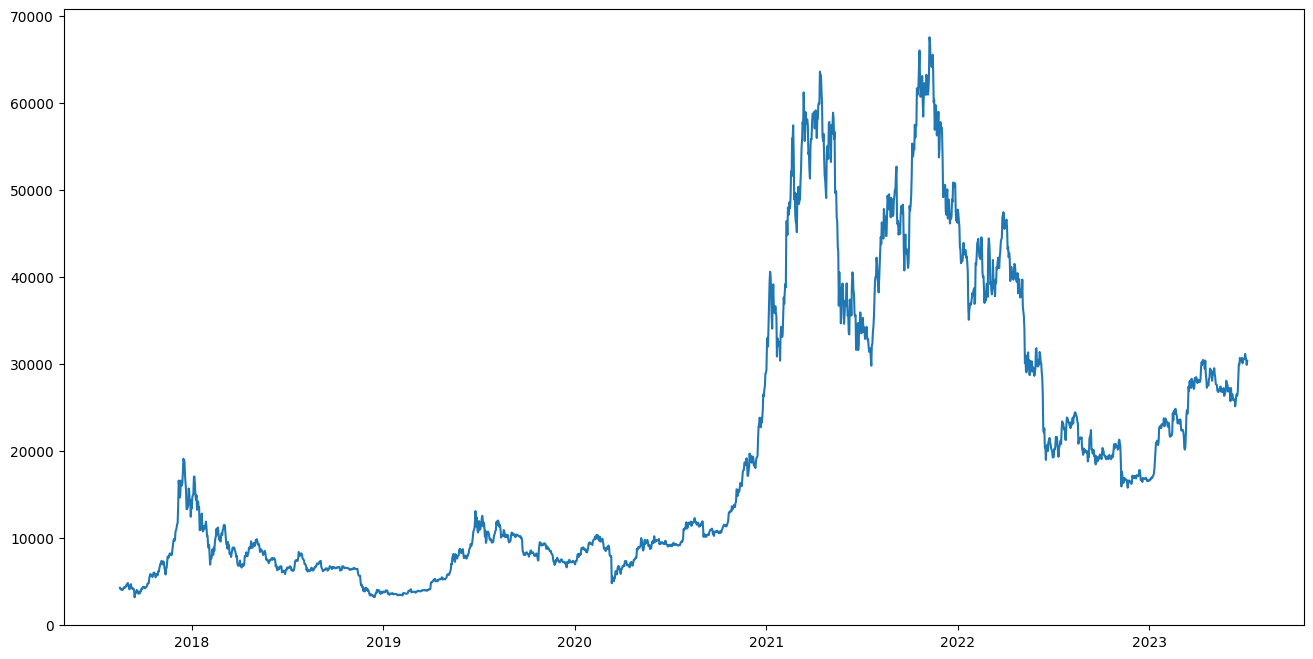

In [3]:
df["Date"]=pd.to_datetime(df.Date,format="mixed")
df.index=df['Date']
plt.figure(figsize=(16,8))
plt.plot(df["Close"],label='Close Price history')


In [4]:
data=df.sort_index(ascending=True,axis=0)
new_dataset=pd.DataFrame(index=range(0,len(df)),columns=['Date','Close'])
for i in range(0,len(data)):
    new_dataset["Date"][i]=data['Date'][i]
    new_dataset["Close"][i]=data["Close"][i]

In [5]:
new_dataset.index=new_dataset.Date
new_dataset.drop("Date",axis=1,inplace=True)

final_dataset=new_dataset.values

n_train = int(new_dataset.shape[0]/3) * 2
train_data=final_dataset[0:n_train,:]
valid_data=final_dataset[n_train:,:]

scaler=MinMaxScaler(feature_range=(0,1))
scaled_data=scaler.fit_transform(final_dataset)

x_train_data,y_train_data=[],[]

for i in range(60,len(train_data)):
    x_train_data.append(scaled_data[i-60:i,0])
    y_train_data.append(scaled_data[i,0])
    
x_train_data,y_train_data=np.array(x_train_data),np.array(y_train_data)

x_train_data=np.reshape(x_train_data,(x_train_data.shape[0],x_train_data.shape[1],1))

lstm_model=Sequential()
lstm_model.add(LSTM(units=50,return_sequences=True,input_shape=(x_train_data.shape[1],1)))
lstm_model.add(LSTM(units=50))
lstm_model.add(Dense(1))


1374/1374 - 32s - loss: 0.0026 - 32s/epoch - 23ms/step
23/23 [==============================] - 1s 17ms/step


C:\Users\khatu\AppData\Local\Temp\ipykernel_1700\799007914.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valid_data['Predictions']=predicted_closing_price


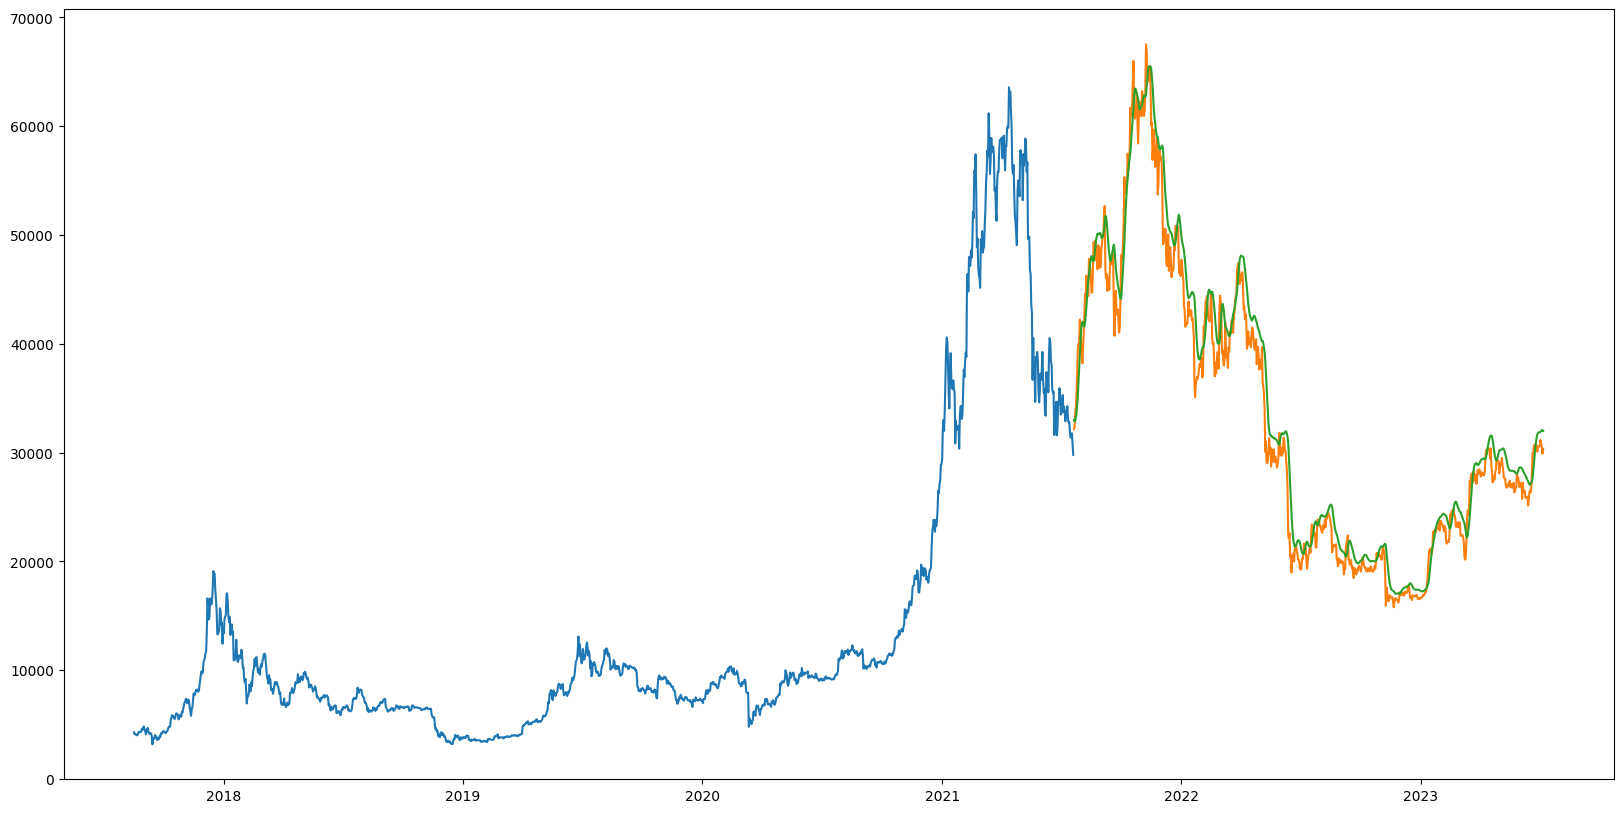

In [6]:

lstm_model.compile(loss='mean_squared_error',optimizer='adam')
lstm_model.fit(x_train_data,y_train_data,epochs=1,batch_size=1,verbose=2)

inputs_data=new_dataset[len(new_dataset)-len(valid_data)-60:].values
inputs_data=inputs_data.reshape(-1,1)
inputs_data=scaler.transform(inputs_data)


X_test=[]
for i in range(60,inputs_data.shape[0]):
    X_test.append(inputs_data[i-60:i,0])
X_test=np.array(X_test)

X_test=np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
predicted_closing_price=lstm_model.predict(X_test)
predicted_closing_price=scaler.inverse_transform(predicted_closing_price)

lstm_model.save("./Model/btc_model.keras")
n = X_test.shape[0]
train_data=new_dataset[0:-n]
valid_data=new_dataset[-n:]
valid_data['Predictions']=predicted_closing_price
plt.plot(train_data["Close"])
plt.plot(valid_data[['Close',"Predictions"]])